In [2]:
import random
import time
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn import preprocessing
from scipy import sparse
from tqdm import tqdm
from collections import Counter

In [3]:
train_pd = pd.read_csv("./data/train.csv", encoding="utf-8")

print("get word_list & vocab_list")
word_list = []
vocab_list = []
for line in tqdm(train_pd.value):
    word_list.append([w for w in line])
    vocab_list.extend([w for w in line])
    
print("get vocab")
c = Counter(vocab_list)
vocab = np.array(list(c.keys()))
vocab.sort()
print(vocab)

print("lable encoder vocab")
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(vocab)
print(label_encoder.classes_)
# label_encoder.transform(vocab)

print("label encoder word_list")
word_labelencoder = [list(label_encoder.transform(w)) for w in word_list]
word_size = [len(i) for i in word_labelencoder]

print("balanced pos & neg data")
train_size_pd = pd.DataFrame(word_size, columns=['len'])
train_size_pd['label'] = train_pd.label
# train_size_pd.describe()
train_size_pd = train_size_pd[train_size_pd.len < 500]
print(Counter(train_size_pd.label))

pos_index = train_size_pd[train_size_pd.label == 1].index.values
random.shuffle(pos_index)
print(pos_index, pos_index.shape)

neg_index = train_size_pd[train_size_pd.label == 0].index.values
neg_index = np.random.choice(neg_index, size=4000-1973)
print(neg_index, neg_index.shape)

balance_train_index = np.append(pos_index,neg_index)
random.shuffle(balance_train_index)
print(balance_train_index, balance_train_index.shape)

print("get data")
x_batch = np.array(word_labelencoder.copy())
x_batch = x_batch[balance_train_index]
y_batch = np.array(train_pd.label.copy())
y_batch = y_batch[balance_train_index]
x_batch_size = [len(i) for i in x_batch]
print(x_batch.shape, y_batch.shape, len(x_batch_size))

print("padding & one-hot x data")
max_size = np.max(x_batch_size)
x_batch_pad = []
for x in tqdm(x_batch[:]):
    list_test = list()
    list_test =([-1] * max_size)
    list_test[:len(x)] = x
#     list_test = [[i] for i in list_test]
    x_batch_pad.append(list_test)
x_batch_pad = [np.eye(len(vocab))[item] for item in x_batch_pad]
   
print("padding & one-hot y data")
y_batch_pad = [np.eye(2)[item] for item in y_batch]
y_batch_pad = [list(i) for i in y_batch_pad]

print("success")

100%|██████████| 30000/30000 [00:00<00:00, 202847.13it/s]

get word_list & vocab_list
get vocab



100%|██████████| 4000/4000 [00:00<00:00, 198171.70it/s]

['%' '&' '*' '+' '-' '.' '0' '1' '2' '3' '4' '5' '6' '7' '8' '9' '=' 'A'
 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S'
 'T' 'U' 'V' 'W' 'X' 'Y' 'Z' '_' 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j'
 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r' 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']
lable encoder vocab
['%' '&' '*' '+' '-' '.' '0' '1' '2' '3' '4' '5' '6' '7' '8' '9' '=' 'A'
 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S'
 'T' 'U' 'V' 'W' 'X' 'Y' 'Z' '_' 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j'
 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r' 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']
label encoder word_list
balanced pos & neg data
Counter({0: 27159, 1: 1973})
[22711  9697 16625 ..., 18772 19756 14326] (1973,)
[ 4627 12583 16125 ..., 28782 13371 23390] (2027,)
[26111  8119  4407 ..., 22433  6317 16059] (4000,)
get data
(4000,) (4000,) 4000
padding & one-hot x data


padding & one-hot y data
success


In [4]:
class Batcher():
    def __init__(self, x, y, x_batch_size):
        self.split_size = int(len(x)*0.8)
        self.train_x = x[:self.split_size]
        self.train_y = y[:self.split_size]
        self.train_size = x_batch_size[:self.split_size]
        self.test_x = x[self.split_size:]
        self.test_y = y[self.split_size:]
        self.test_size = x_batch_size[self.split_size:]
        self.start = 0
    def next_batch(self, batch_size):
        s_index = self.start
        e_index = self.start + batch_size
        if e_index >= self.split_size:
            self.start = 0
            s_index = self.start
            e_index = self.start + batch_size
        self.start = e_index
        return self.train_x[s_index:e_index], self.train_y[s_index:e_index], self.train_size[s_index:e_index]

In [5]:
sqli_batch = Batcher(x_batch_pad, y_batch_pad, x_batch_size)

In [6]:
batch_data, batch_labels, batch_seqlen = sqli_batch.next_batch(10)

In [7]:
batch_data[:2]

[array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  1.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  1.],
        [ 0.,  0.,  0., ...,  0.,  0.,  1.],
        [ 0.,  0.,  0., ...,  0.,  0.,  1.]]),
 array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  1.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  1.],
        [ 0.,  0.,  0., ...,  0.,  0.,  1.],
        [ 0.,  0.,  0., ...,  0.,  0.,  1.]])]

In [8]:
batch_labels

[[1.0, 0.0],
 [1.0, 0.0],
 [0.0, 1.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [0.0, 1.0],
 [0.0, 1.0],
 [1.0, 0.0],
 [1.0, 0.0]]

In [9]:
batch_seqlen

[40, 37, 131, 61, 88, 76, 146, 238, 142, 107]

In [10]:
tf.reset_default_graph()

# Parameters
learning_rate = 0.01
training_steps = 500
batch_size = 100
display_step = 50

# Network Parameters
seq_max_len = max_size # Sequence max length
forward_units = 128 # hidden layer num of features
backward_units = 128 # hidden layer num of features
n_classes = 2 # linear sequence or not

# Batcher zeroday_batch
sqli_batch = Batcher(x_batch_pad, y_batch_pad, x_batch_size)

# tf Graph input
x = tf.placeholder("float", [None, seq_max_len, len(vocab)])
y = tf.placeholder("float", [None, n_classes])
# A placeholder for indicating each sequence length
seqlen = tf.placeholder(tf.int64, [None,])

    
with tf.variable_scope("bi-GRU") as scope:
    # Define a lstm cell with tensorflow
    encoder_fw = tf.contrib.rnn.GRUCell(forward_units)
    encoder_bw = tf.contrib.rnn.GRUCell(backward_units)

    outputs, _ = tf.nn.bidirectional_dynamic_rnn(cell_fw=encoder_fw, 
                                            cell_bw=encoder_bw, 
                                            inputs=x,
                                            sequence_length=seqlen,
                                            dtype=tf.float32)

    print(outputs)
    output = tf.concat(outputs, 2)
    print(output)
#     batch_size = output.get_shape().as_list()[0]
    reshape = tf.reshape(output, [-1, forward_units + backward_units])
    print(reshape)
    
with tf.variable_scope("output"):
    softmax_w = tf.get_variable("softmax_w",
                                shape=[forward_units + backward_units, n_classes],
                                initializer=tf.truncated_normal_initializer(stddev=0.05),
                                dtype=tf.float32)
    softmax_b = tf.get_variable("softmax_b",
                                shape=[n_classes],
                                initializer=tf.constant_initializer(value=0.),
                                dtype=tf.float32)
    xw_plus_b = tf.nn.xw_plus_b(reshape, softmax_w, softmax_b)
    print("xw_plus_b:", xw_plus_b)
    logits = tf.reshape(xw_plus_b, [-1, seq_max_len, n_classes])
    print("logits:", logits)
    logits_softmax = tf.nn.softmax(logits)
#     logits = tf.nn.softmax(logits)

with tf.name_scope("loss"):
#     print(tf.gather(logits, [1], axis=2))
    logits_label = tf.reshape(tf.gather(logits, [1], axis=2), [-1, seq_max_len])
    print("logits_label:", logits_label)
#     logits_score = tf.reduce_max(logits_label, axis=1)
    logits_index = tf.cast(tf.argmax(logits_label, axis=1), tf.int32)
    print(logits_index)
    print(seq_max_len, batch_size)
    batch_size_ = tf.shape(logits)[0]
    logits_index = tf.range(0, batch_size_) * seq_max_len + logits_index
    print(logits_index)
#     print(logits)
    logits_reshape = tf.reshape(logits, [-1, n_classes])
#     print(tf.gather(logits_reshape, logits_index, axis=0))
    logits_max = tf.reshape(tf.gather(logits_reshape, logits_index, axis=0), [-1, n_classes])
    print("logits_max:", logits_max, y)
    loss_per_example_average = tf.nn.softmax_cross_entropy_with_logits(logits=logits_max, labels=y, name="loss")
#     print(fake_loss)
#     y_sum = tf.reduce_sum(y, axis=1)
#     print(y_sum)
#     mask = tf.cast(tf.sign(y_sum), dtype=tf.float32)
#     print(mask)
#     loss_per_example_per_step = tf.multiply(fake_loss, mask)
#     print(loss_per_example_per_step)
#     loss_per_example_sum = tf.reduce_sum(loss_per_example_per_step, reduction_indices=[1])
#     print(loss_per_example_sum)
#     loss_per_example_average = tf.div(x=loss_per_example_sum,
#                                       y=tf.cast(seqlen, tf.float32))
#     print(loss_per_example_average)
    loss = tf.reduce_mean(loss_per_example_average, name="loss")
    print("loss:", loss)

with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss, name="train_op")
    
with tf.name_scope("valid"):
    predict = tf.argmax(logits_max, axis=1)
    print("predict:", predict)
    y_arg = tf.argmax(y, axis=1)
    print("y_arg:", y_arg)
    accuracy_per_example = tf.cast(tf.equal(predict, y_arg), dtype=tf.float32, name="valid_accuracy")
#     accuracy_matrix = tf.multiply(fake_accuracy, mask)
#     accuracy_per_example = tf.div(x=tf.reduce_sum(accuracy_matrix, 1),
#                                   y=tf.cast(seqlen, tf.float32))
    accuracy = tf.reduce_mean(accuracy_per_example, name="valid_accuracy")

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

(<tf.Tensor 'bi-GRU/bidirectional_rnn/fw/fw/transpose:0' shape=(?, 499, 128) dtype=float32>, <tf.Tensor 'bi-GRU/ReverseSequence:0' shape=(?, 499, 128) dtype=float32>)
Tensor("bi-GRU/concat:0", shape=(?, 499, 256), dtype=float32)
Tensor("bi-GRU/Reshape:0", shape=(?, 256), dtype=float32)
xw_plus_b: Tensor("output/xw_plus_b:0", shape=(?, 2), dtype=float32)
logits: Tensor("output/Reshape:0", shape=(?, 499, 2), dtype=float32)
logits_label: Tensor("loss/Reshape:0", shape=(?, 499), dtype=float32)
Tensor("loss/Cast:0", shape=(?,), dtype=int32)
499 100
Tensor("loss/add:0", shape=(?,), dtype=int32)
logits_max: Tensor("loss/Reshape_2:0", shape=(?, 2), dtype=float32) Tensor("Placeholder_1:0", shape=(?, 2), dtype=float32)
loss: Tensor("loss/loss_1:0", shape=(), dtype=float32)


/home/renxinzhang/.conda/envs/tf-gpu-1.3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


predict: Tensor("valid/ArgMax:0", shape=(?,), dtype=int64)
y_arg: Tensor("valid/ArgMax_1:0", shape=(?,), dtype=int64)


In [33]:
LOG_DIR = "./logs/biGRU-07/"
saver = tf.train.Saver(tf.global_variables(), max_to_keep=15)
module_file = tf.train.latest_checkpoint(LOG_DIR)

# Start training
config = tf.ConfigProto()  
config.gpu_options.allow_growth=True  
with tf.Session(config=config) as sess:
    tf.summary.scalar("loss", loss)
    tf.summary.scalar("acc", accuracy)
        
    merged = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter(LOG_DIR + "train/", sess.graph)

    # Run the initializer
    sess.run(init)
#     saver.restore(sess, module_file)

    for step in range(1, training_steps + 1):
        # Get batch data
        batch_x, batch_y, batch_seqlen = sqli_batch.next_batch(batch_size)
        # Run optimization op (backprop)
        _, summary_ = sess.run([train_op, merged], feed_dict={x: batch_x, y: batch_y, seqlen: batch_seqlen})
        train_writer.add_summary(summary_, step)
        
        if step % display_step == 0 or step == 1:
            # Calculate batch accuracy & loss
            acc, cost = sess.run([accuracy, loss], feed_dict={x: batch_x, y: batch_y,
                                                seqlen: batch_seqlen})
            print("Step " + str(step*batch_size) + ", Minibatch Loss= " + \
                  "{:.6f}".format(cost) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc))
            
            # Calculate accuracy
            test_data = sqli_batch.test_x
            test_label = sqli_batch.test_y
            test_seqlen = sqli_batch.test_size
            test_acc = sess.run(accuracy, feed_dict={x: test_data, y: test_label, seqlen: test_seqlen})
            print("Testing Accuracy:", test_acc)
        if step % 5 == 0:
            saver.save(sess, LOG_DIR+"sqli.ckpt", global_step=step)

    print("Optimization Finished!")

    # Calculate accuracy
    test_data = sqli_batch.test_x
    test_label = sqli_batch.test_y
    test_seqlen = sqli_batch.test_size
    test_acc = sess.run(accuracy, feed_dict={x: test_data, y: test_label, seqlen: test_seqlen})
    print("Testing Accuracy:", test_acc)

Step 100, Minibatch Loss= 0.590807, Training Accuracy= 0.97000
Testing Accuracy: 0.94125
Step 5000, Minibatch Loss= 0.231795, Training Accuracy= 0.97000
Testing Accuracy: 0.96125
Step 10000, Minibatch Loss= 0.112103, Training Accuracy= 0.99000
Testing Accuracy: 0.98875
Step 15000, Minibatch Loss= 0.067148, Training Accuracy= 1.00000
Testing Accuracy: 0.9775
Step 20000, Minibatch Loss= 0.074165, Training Accuracy= 0.98000
Testing Accuracy: 0.99125
Step 25000, Minibatch Loss= 0.028191, Training Accuracy= 1.00000
Testing Accuracy: 0.99625
Step 30000, Minibatch Loss= 0.015304, Training Accuracy= 1.00000
Testing Accuracy: 0.9975
Step 35000, Minibatch Loss= 0.017751, Training Accuracy= 1.00000
Testing Accuracy: 0.9925
Step 40000, Minibatch Loss= 0.013518, Training Accuracy= 1.00000
Testing Accuracy: 0.99375
Step 45000, Minibatch Loss= 0.011233, Training Accuracy= 1.00000
Testing Accuracy: 0.9925
Step 50000, Minibatch Loss= 0.010052, Training Accuracy= 1.00000
Testing Accuracy: 0.99625
Optimi

In [11]:
LOG_DIR = "./logs/biGRU-07/"
saver = tf.train.Saver(tf.global_variables(), max_to_keep=15)
module_file = tf.train.latest_checkpoint(LOG_DIR)

test_pred = ''
# Start training
config = tf.ConfigProto()  
config.gpu_options.allow_growth=True  
# sess = tf.Session(config=config) 
with tf.Session(config=config) as sess:
    
    saver.restore(sess, module_file)

    # Calculate accuracy
    test_data = sqli_batch.test_x
    test_label = sqli_batch.test_y
    test_seqlen = sqli_batch.test_size
    test_pred, test_acc, test_logits, test_logits_label = sess.run([logits_max, accuracy, logits_softmax, logits_label], \
                                                feed_dict={x: test_data, y: test_label, seqlen: test_seqlen})
#     test_logits_reshape, test_logits_index = sess.run([logits_reshape, logits_index], \
#                                                 feed_dict={x: test_data, y: test_label, seqlen: test_seqlen})
    print("Testing Accuracy:", test_acc)

INFO:tensorflow:Restoring parameters from ./logs/biGRU-07/sqli.ckpt-500
Testing Accuracy: 0.99875


In [13]:
test_pred_label = np.argmax(test_pred, 1)
test_real_label = np.argmax(test_label, 1)
test_diff = test_pred_label != test_real_label
test_diff_index = np.where(test_diff == True)[0]
print("diff len:", len(test_diff_index))

x_batch_lbl = np.array(word_labelencoder.copy())
x_batch_lbl = x_batch_lbl[balance_train_index]
word_list_array = np.array(word_list)
test_data = word_list_array[balance_train_index][int(0.8*len(balance_train_index)):]
print("get test data")

diff_data = test_data[test_diff_index]
# print(diff_data)
diff_data_str = []
for data in diff_data:
    diff_data_str.append("".join(data))
#     print("".join(data))
print("get diff raw data")

test_data_all = np.array(train_pd.label.copy())
test_data_y = test_data_all[balance_train_index][int(0.8*len(balance_train_index)):]

print("test_pred_label", test_pred_label[test_diff_index])
print("test_real_label", test_real_label[test_diff_index])
print("    test_data_y", test_data_y[test_diff_index])

diff len: 1
get test data
get diff raw data
test_pred_label [0]
test_real_label [1]
    test_data_y [1]


In [14]:
diff_pd = pd.DataFrame(diff_data_str, columns=['urldata'])
diff_pd['pred'] = test_pred_label[test_diff_index]
diff_pd['real'] = test_real_label[test_diff_index]
diff_pd['label'] = test_data_y[test_diff_index]
diff_pd['id'] = test_diff_index
# diff_pd.to_csv("./data/007#bi-GRU-MaxPool.csv", index=False)

In [15]:
diff_pd

,urldata,pred,real,label,id
0,keyone=1477219329816_186&keytwo=c%27++order+by+99,0,1,1,536


In [23]:
test_logits.shape

(800, 499, 2)

In [16]:
show_index = 536
print("".join(test_data[show_index]))
heatmap_x = test_data[show_index]
sampe_score = [item[1] for item in test_logits[show_index]]
# heatmap_y = [[item] for item in sampe_score]
heatmap_y = [sampe_score[:len(heatmap_x)]]

keyone=1477219329816_186&keytwo=c%27++order+by+99


No handles with labels found to put in legend.


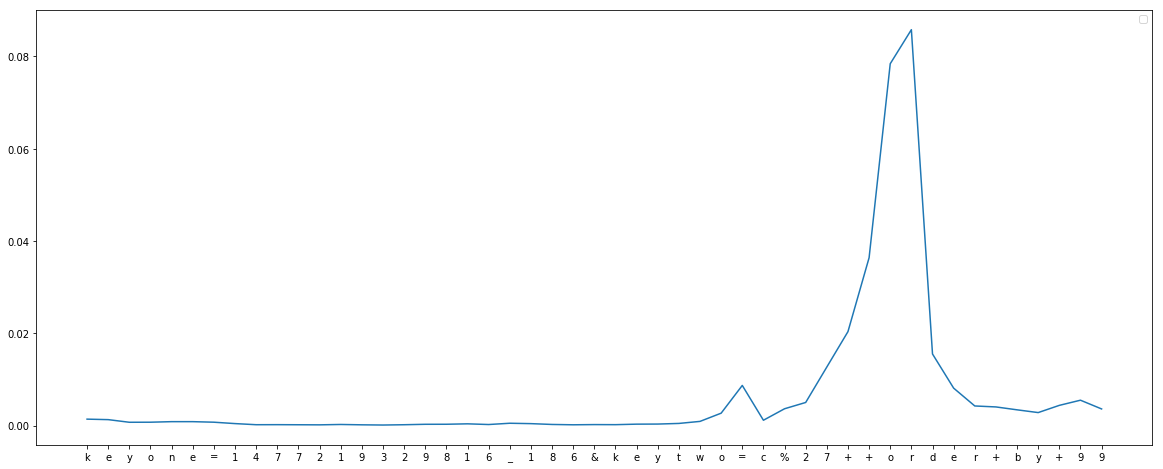

In [17]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(20, 8)) # set figure size
plt.plot(heatmap_y[0][:len(heatmap_x)])
xticks = range(0,len(heatmap_x))
ax.set_xticks(xticks) # major ticks
ax.set_xticklabels(heatmap_x)   # labels should be 'unicode'
plt.legend(loc='upper right')
plt.show()

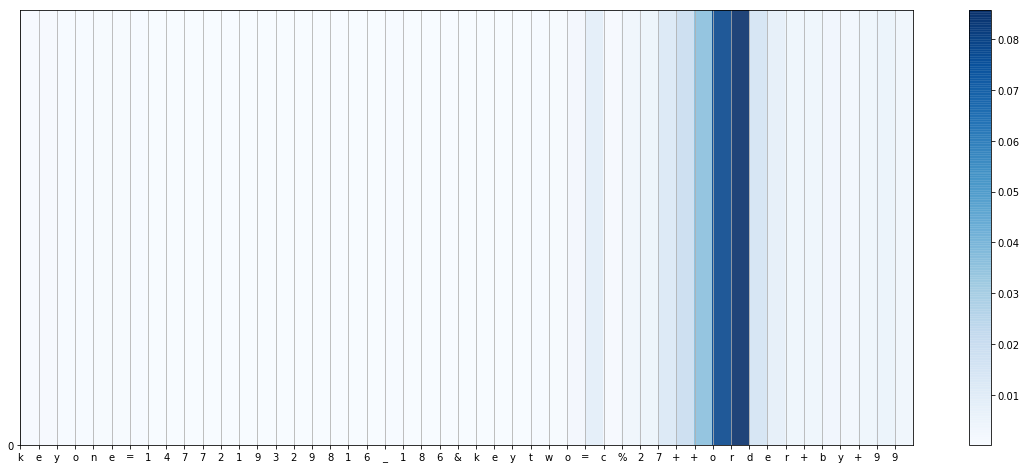

In [21]:
import matplotlib.pyplot as plt

plt.figure()
fig, ax = plt.subplots(figsize=(20, 8)) # set figure size
heatmap = ax.pcolor(heatmap_y, cmap=plt.cm.Blues, alpha=0.9)
xticks = range(0,len(heatmap_x))
ax.set_xticks(xticks, minor=False) # major ticks
ax.set_xticklabels(heatmap_x, minor = False, rotation=0)   # labels should be 'unicode'

yticks = list(range(0,1))
ax.set_yticks(yticks, minor=False)
# ax.set_yticklabels(Y_label, minor = False)   # labels should be 'unicode'

ax.grid(True)
plt.colorbar(heatmap)